In [2]:
pip install --force-reinstall git+https://github.com/meerakota/ucla_plha.git

  Cloning https://github.com/meerakota/ucla_plha.git to c:\users\sjbra\appdata\local\temp\pip-req-build-wt2yr94u
  Resolved https://github.com/meerakota/ucla_plha.git to commit 8a68d89aa63c9dd87d1cb95d72b65358ca056bee
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached numpy-2.3.4-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached attrs-2

  Running command git clone --filter=blob:none --quiet https://github.com/meerakota/ucla_plha.git 'C:\Users\sjbra\AppData\Local\Temp\pip-req-build-wt2yr94u'
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.3.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Validation of ground motion models

The purpose of this notebook is to validate our implementation of the four ground motion models. We have gathered images of relevant figures from the original references, and overlaid the corresponding data generated using the ucla_plha code. The original papers use lines of various color to represent ground motion vs. distance, and results from the ucla_plha code are shown as symbols using the same color scheme as the figures from the original papers. The figures often include plots of multiple intensity measures vs. distance. We have opted to include the entire figure even though we are only comparing with PGA. Furthermore, when PGA is not available, we use pseudo-spectral acceleration at 0.01s, which is adequately close to PGA for validation purposes. Alignment of the image and the data plot is performed by visual inspection and iteration, and is not perfect. For further validation, we have also plotted data points using the [pygmm](https://github.com/arkottke/pygmm) package using small symbols inside of the ucla_plha symbols. 

C:\Users\sjbra\anaconda3\Lib\site-packages\pygmm\model.py:175: UserWarning: dist_rup (300.0000000000001) is greater than the recommended limit ({self.max}).
  self._scenario[p.name] = p.check(self._scenario[p.name])


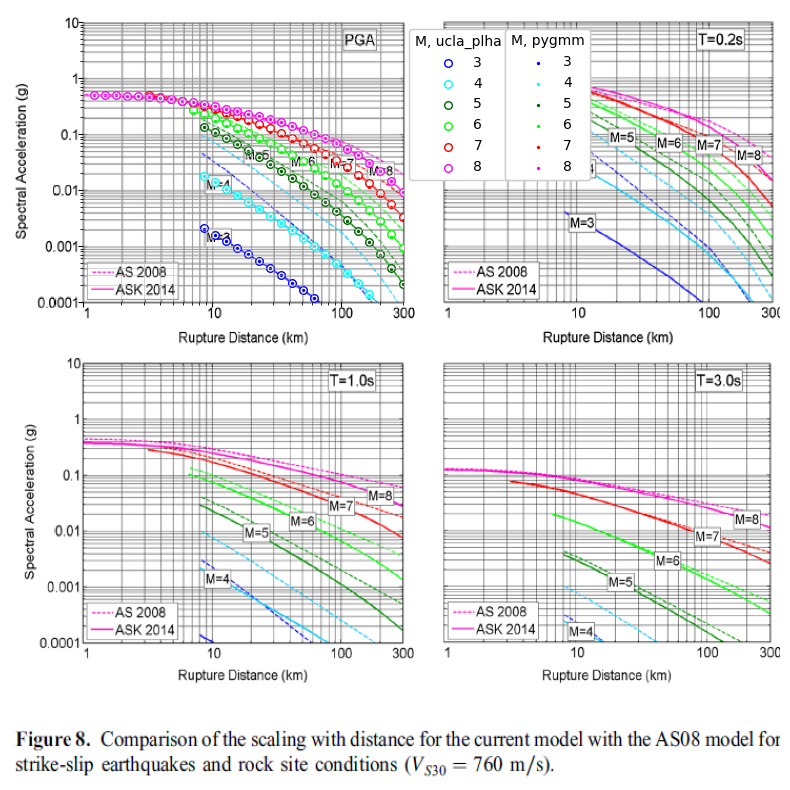

In [3]:
# Reproduce Fig. 8 from ASK model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import ask14
import pygmm

rrup_vec = np.logspace(0, np.log10(300), 30)
m_vec = np.asarray([3, 4, 5, 6, 7, 8])
rrup_lim = np.asarray([8, 8, 8, 6.5, 3.0, 1.0])
ztor_vec = np.asarray([8, 8, 8, 6.5, 3.0, 0.0])
colors = np.asarray(["blue", "cyan", "darkgreen", "lime", "red", "magenta"])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)

vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rjb = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
ry0 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.zeros(len(m))
measured_vs30 = True

I = 0
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        ztor[I] = ztor_vec[i]
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I], 
            dist_x = rx[I], 
            dist_rup = rrup[I], 
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'SS',
            on_hanging_wall = True,
        )
        pygmm_output = pygmm.AbrahamsonSilvaKamai2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1



mu_ln, sigma_ln = ask14.get_im(
    vs30, rrup, rx, rx1, ry0, m, fault_type, measured_vs30, dip, ztor, z1=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))

image = mpimg.imread("ask14_fig8.png")
ax_img.imshow(image, extent=[0,6,0,6])
ax_img.axis("off")
ax_data = fig.add_axes((0.2,0.588,0.32,0.28), frameon=False)
ax_data.set_xscale('log')
ax_data.set_yscale('log')
ax_data.grid(True, alpha=0.5, which="both")
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor="white",
        s=30
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga_pygmm[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        color=colors[i],
        s=2,
        clip_on = True,
    )
    pygmm_scatter.append(temp)

ax_data.set_ylim(0.0001, 10)
ax_data.set_xlim(1, 300)

first_legend = ax_data.legend(handles = ucla_plha_scatter, title="M, ucla_plha", loc='upper left', bbox_to_anchor=(1.0,1.0,0,0), framealpha=1.0)
second_legend = ax_data.legend(handles = pygmm_scatter, title="M, pygmm", loc='upper left', bbox_to_anchor=(1.3,1.0,0,0), framealpha=1.0)
ax_data.add_artist(first_legend)
ax_data.add_artist(second_legend)
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

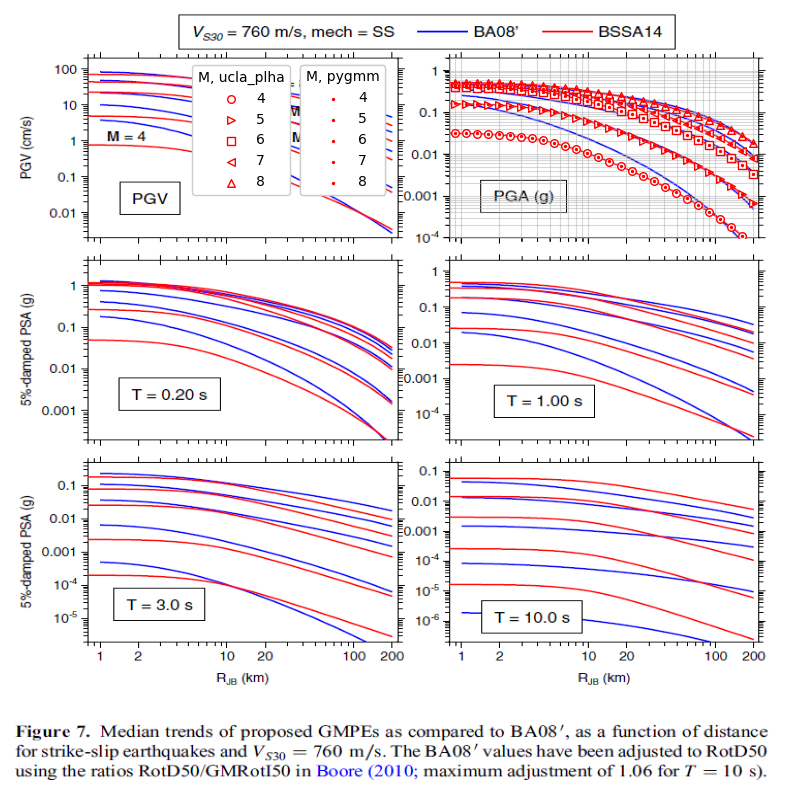

In [4]:
# Reproduce PGA part of Fig. 7 from BSSA14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import bssa14

rjb_vec = np.logspace(np.log(0.8), np.log10(200), 30)
m_vec = np.asarray([4, 5, 6, 7, 8])
rjb = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
m = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
vs30 = 760
fault_type = np.full(len(m), 3)
dip = np.full(len(m), 90)
I = 0
pga_pygmm = np.empty(len(m))
for i in range(len(m_vec)):
    for j in range(len(rjb_vec)):
        m[I] = m_vec[i]
        rjb[I] = rjb_vec[j]
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I], 
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'SS',
        )
        pygmm_output = pygmm.BooreStewartSeyhanAtkinson2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1



mu_ln, sigma_ln = bssa14.get_im(vs30, rjb, m, fault_type)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))
image = mpimg.imread("bssa14_fig7.png")
ax_img.imshow(image, extent=[6,0,6,0])
ax_img.axis("off")

markers = ['o', '>', 's', '<', '^']

ax_data = fig.add_axes((0.566,0.6525,0.310,0.1795), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rjb[m == m_val],
        pga[m == m_val],
        label=str(m_val),
        edgecolor='red',
        facecolor='white', 
        s=30, 
        marker=markers[i],
        zorder=2
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rjb[m == m_val],
        pga_pygmm[m == m_val],
        label=str(m_val),
        color='red',
        s=2,
        zorder=3,
    )
    pygmm_scatter.append(temp)
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 2)
ax_data.set_xlim(0.8, 220)
first_legend = ax_data.legend(handles = ucla_plha_scatter, title="M, ucla_plha", loc='upper left', bbox_to_anchor=(-0.85,1.0,0,0), framealpha=1.0)
second_legend = ax_data.legend(handles = pygmm_scatter, title="M, pygmm", loc='upper left', bbox_to_anchor=(-0.5,1.0,0,0), framealpha=1.0)
ax_data.add_artist(first_legend)
ax_data.add_artist(second_legend)
ax_data.grid(True, alpha=0.5, which="both")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

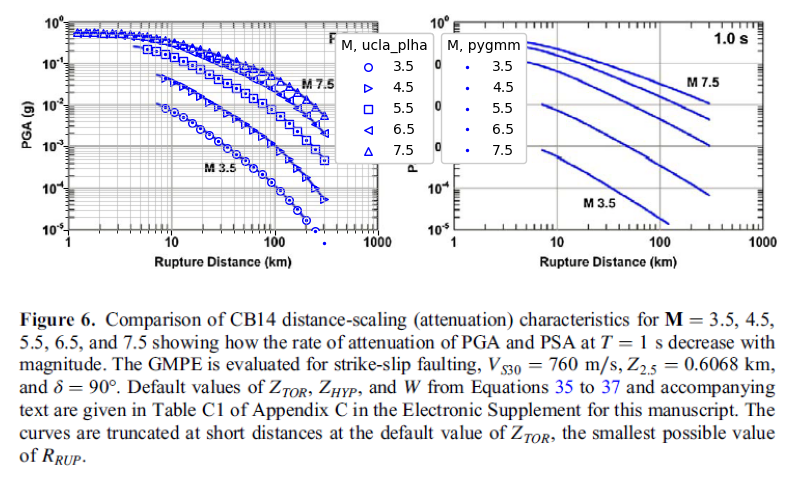

In [5]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cb14

rrup_vec = np.logspace(0, np.log10(300), 30)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5])
rrup_lim = np.asarray([8, 8, 5, 1.0, 1.0])
ztor_vec = np.asarray([8, 8, 5, 0.0, 0.0])
colors = np.asarray(["blue", "cyan", "darkgreen", "lime", "red", "magenta"])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.empty(len(m))
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        rjb[I] = rrup_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        W = np.sqrt(10 ** ((m[I] - 4.07) / 0.98))
        zhyp[I] = ztor[I] - 0.5 * W * np.sin(dip[I] * np.pi / 180.0)
        zbor[I] = ztor[I] + W
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I],
            dist_rup = rrup[I],
            dist_x = rx[I],
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'SS',
        )
        pygmm_output = pygmm.CampbellBozorgnia2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1


mu_ln, sigma_ln = cb14.get_im(vs30, rjb, rrup, rx, rx1, m, fault_type, ztor, zbor, dip)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10, 10))

image = mpimg.imread("cb14_fig6.png")
ax_img.imshow(image)
ax_img.axis("off")
markers = ['o', '>', 's', '<', '^']
ax_data = fig.add_axes((0.183,0.505,0.31,0.208), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        facecolor = 'white',
        edgecolor = 'blue',
        marker = markers[i],
        s = 30
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga_pygmm[(m == m_val) & (rrup > rrup_lim[i])],
        color= 'blue',
        label = str(m_val),
        s=2,
        clip_on = False,
    )
    pygmm_scatter.append(temp)
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.00001, 1)
ax_data.set_xlim(1, 1000)
legend1 = ax_data.legend(title="M, ucla_plha", handles=ucla_plha_scatter, loc='upper right', bbox_to_anchor=(1.2,0.98,0,0), framealpha=1.0)
ax_data.add_artist(legend1)
legend2 = ax_data.legend(title="M, pygmm", handles=pygmm_scatter, loc='upper right', bbox_to_anchor=(1.5,0.98,0,0), framealpha=1.0)
ax_data.add_artist(legend1)
ax_data.grid(True, alpha=0.5, which="both")
# ax_data.set_xlabel("Rupture Distance (km)")
# ax_data.set_ylabel("PGA (g)")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

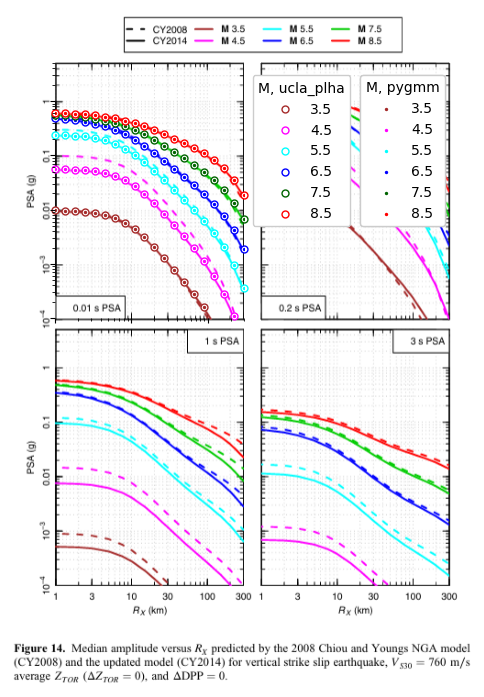

In [31]:
# Reproduce Fig. 14 from CY14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cy14

rx_vec = np.logspace(0, np.log10(299), 20)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5, 8.5])
colors = np.asarray(["brown", "magenta", "cyan", "blue", "darkgreen", "red"])
rrup = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rx = np.empty(len(m_vec) * len(rx_vec), dtype=float)
m = np.empty(len(m_vec) * len(rx_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.zeros(len(m))
for i in range(len(m_vec)):
    for j in range(len(rx_vec)):
        m[I] = m_vec[i]
        rx[I] = rx_vec[j]
        rjb[I] = rx_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        rrup[I] = np.sqrt(rx[I] ** 2 + ztor[I] ** 2)
        s = pygmm.model.Scenario(
            mag = m[I], dist_jb = rjb[I], dist_x = rx[I], dist_rup = rrup[I], dip = dip[I], v_s30 = vs30, mechanism='SS'
        )
        pygmm_output = pygmm.ChiouYoungs2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1

measured_vs30 = False
mu_ln, sigma_ln = cy14.get_im(
    vs30, rjb, rrup, rx, m, fault_type, measured_vs30, dip, ztor, z1p0=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 10))

image = mpimg.imread("cy14_fig14.png")
ax_img.imshow(image)
ax_img.axis("off")
ax_data = fig.add_axes((0.2,0.525,0.315,0.255), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rx[(m == m_val) & (pga > 1.e-4)],
        pga[(m == m_val) & (pga > 1.e-4)],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=25,
        clip_on = False
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rx[(m == m_val) & (pga > 1.e-4)],
        pga_pygmm[(m == m_val) & (pga > 1.e-4)],
        label=str(m_val),
        color=colors[i],
        s=2,
    )
    pygmm_scatter.append(temp)
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 5)
ax_data.set_xlim(1, 300)
legend1 = ax_data.legend(title="M, ucla_plha", handles=ucla_plha_scatter, loc='upper right', bbox_to_anchor=(1.6,0.98,0,0), alignment='center', framealpha=1.0)
ax_data.add_artist(legend1)
legend2 = ax_data.legend(title="M, pygmm", handles=pygmm_scatter, loc='upper right', bbox_to_anchor=(2.1,0.98,0,0), alignment='center', framealpha=1.0)
ax_data.add_artist(legend2)
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

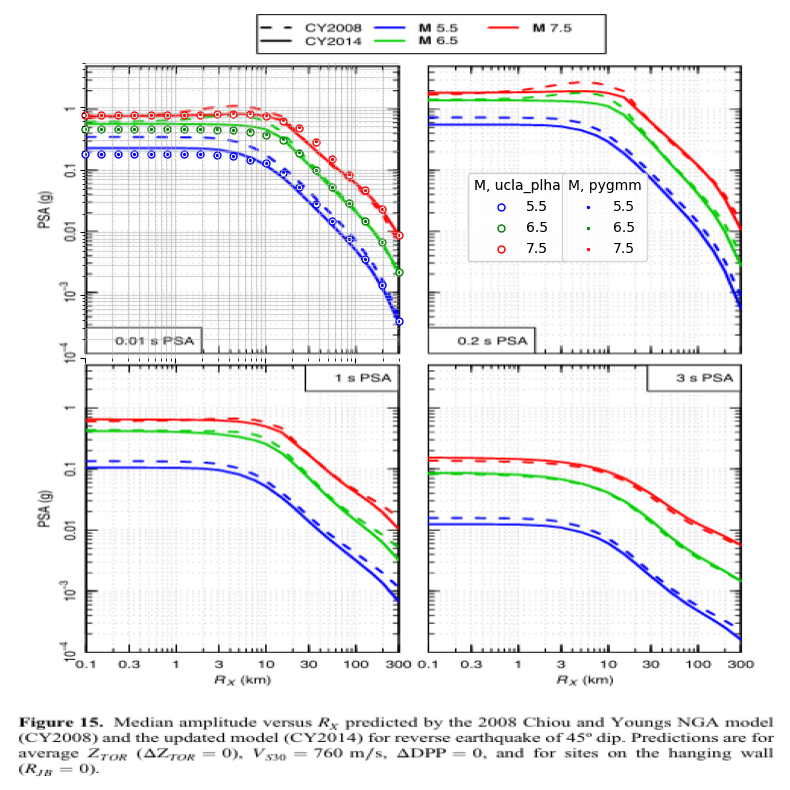

In [33]:
# Reproduce Fig. 15 from CY14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cy14
import pygmm

rx_vec = np.logspace(-1, np.log10(300), 20)
m_vec = np.asarray([5.5, 6.5, 7.5])
rrup = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rx = np.empty(len(m_vec) * len(rx_vec), dtype=float)
m = np.empty(len(m_vec) * len(rx_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zbot = 15.0
I = 0
vs30 = 760
dip = np.full(len(m), 45.0)
fault_type = np.full(len(m), 1)
pga_pygmm = np.zeros(len(m))
for i in range(len(m_vec)):
    for j in range(len(rx_vec)):
        m[I] = m_vec[i]
        rx[I] = rx_vec[j]
        # The equation below if for reverse faults, and should therefore be used to reproduce Fig. 15
        ztor[I] = np.max([2.704 - 1.226 * np.max([m[I] - 5.849, 0]), 0]) ** 2
        # The equation below if for normal and strike slip faults, but produces better agreement with Fig. 15
        # ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        w = 10 ** (-1.61 + 0.41 * m[I])
        if(ztor[I] + w / np.sqrt(2) > zbot):
            w = (zbot - ztor[I]) * np.sqrt(2)       
        if(rx[I] > 2 * w / np.sqrt(2)):
            rrup[I] = np.sqrt((rx[I] - w / np.sqrt(2)) ** 2 + (ztor[I] + w / np.sqrt(2)) ** 2)
        elif((rx[I] <= 2 * w / np.sqrt(2)) & (rx[I] > ztor[I])):
            rrup[I] = (rx[I] + ztor[I]) / np.sqrt(2)
        else:
            rrup[I] = np.sqrt(rx[I] ** 2 + ztor[I] ** 2)
        if(rx[I] < 2 * w / np.sqrt(2)):
            rjb[I] = 0
        else:
            rjb[I] = rx[I] - 2 * w / np.sqrt(2)
       
        s = pygmm.model.Scenario(
            mag = m[I], 
            dist_jb = rjb[I], 
            dist_x = rx[I], 
            dist_rup = rrup[I], 
            dip = dip[I], 
            v_s30 = vs30, 
            mechanism = 'RS',
            on_hanging_wall = True,
            depth_tor = ztor[I]
        )
        pygmm_output = pygmm.ChiouYoungs2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1

measured_vs30 = False
mu_ln, sigma_ln = cy14.get_im(
    vs30, rjb, rrup, rx, m, fault_type, measured_vs30, dip, ztor, z1p0=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(10,10))

image = mpimg.imread("cy14_fig15.png")
ax_img.imshow(image, extent=[6,0,6,0])
ax_img.axis("off")
colors = ['blue', 'green', 'red']
ax_data = fig.add_axes((0.202,0.532,0.314,0.295), frameon=False)
ucla_plha_scatter = []
pygmm_scatter = []
for i, m_val in enumerate(m_vec):
    temp = ax_data.scatter(
        rx[m == m_val],
        pga[m == m_val],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=25,
        clip_on = False
    )
    ucla_plha_scatter.append(temp)
    temp = ax_data.scatter(
        rx[m == m_val],
        pga_pygmm[m == m_val],
        label=str(m_val),
        color=colors[i],
        s=2,
    )
    pygmm_scatter.append(temp)
    
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 5)
ax_data.set_xlim(0.1, 300)
legend1 = ax_data.legend(title="M, ucla_plha", handles=ucla_plha_scatter, loc='upper left', bbox_to_anchor=(1.2,0.65,0,0))
ax_data.add_artist(legend1)
legend2 = ax_data.legend(title="M, pygmm", handles=pygmm_scatter, loc='upper left', bbox_to_anchor=(1.5,0.65,0,0))
ax_data.add_artist(legend1)
ax_data.grid(True, alpha=0.5, which="both")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

# Notes about CY14 validation

Agreement between the ucla_plha code and Fig. 15 is not as good as for the other models, and warrants some discussion. Figure 15 for the CY14 model indicates it is for a reverse fault for sites on the hanging wall ($R_{JB}$ = 0). However, $R_{JB}$ = 0 and $R_x$ = 300 km implies an unreasonable fault geometry for shallow crustal earthquakes, particularly for a $M$ = 5.5 event. Figure 3.5 in their [PEER Report](https://peer.berkeley.edu/publications/2013-07) clearly shows that they did not use $R_{JB}$ = 0 for all values of $R_X$, but rather used a fault width that is consistent with earthquake mangitude, and computed $R_{JB}$ based on the fault geometry. The paper does not specify which fault width was used to prepare Fig. 15. In our validation, we used the fault width formulation by Wells and Coppersmith (2014) to constrain the size of the fault, which means that $R_{JB}$ becomes larger than zero when $R_x$ is large enough to move beyond the surface projection of the bottom of the fault. Furthermore, though not shown in our validation, the bias at short $R_x$ is eliminated if we use the $Z_{TOR}$ equation for normal and strike slip faults instead of the equation for reverse and oblique faults.

The ucla_plha code agrees well with pygmm for all magnitudes and $R_x$ values. Our conclusion is that our implementation of the CY14 model is accurate, but that disagreements in Fig. 15 persist due to unknown differences in the fault width and $Z_{TOR}$ values used to produce the original figure.